<a href="https://colab.research.google.com/github/claudeshyaka/master-project-repo/blob/main/Generating_Simulation_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate Data

In [ ]:
!pip install -q simbench pandapower

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 MB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 101.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 8.4 MB/s eta 0:00:00


## Load Grid Network from Simbench

In [ ]:
import simbench as sb


# Load in the grid data
# 1-LV-rural1--0-sw
# 1-HV-urban--0-sw
grid_code = "1-LV-rural1--0-sw"
net = sb.get_simbench_net(grid_code)
profiles = sb.get_absolute_values(net, profiles_instead_of_study_cases=True)

print(profiles.keys())
print(net)

dict_keys([('load', 'p_mw'), ('load', 'q_mvar'), ('sgen', 'p_mw'), ('gen', 'p_mw'), ('storage', 'p_mw')])
This pandapower network includes the following parameter tables:
   - bus (15 element)
   - load (13 element)
   - sgen (4 element)
   - switch (28 element)
   - ext_grid (1 elements)
   - line (13 element)
   - trafo (1 elements)
   - bus_geodata (15 element)
   - loadcases (6 element)


/usr/local/lib/python3.10/dist-packages/simbench/converter/auxiliary.py:119: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat(dfs, axis=0, **kwargs)


In [ ]:
from matplotlib import colors
import pandapower.plotting as plot
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette()

# Plot the grid network


## Extract Load and Static Generator Profiles

In [ ]:
from pandapower.plotting.plotly import pf_res_plotly
pf_res_plotly(net)

In [ ]:
# Extract the loads and gen profiles
load_p = profiles[("load", "p_mw")]
load_q = profiles[("load", "q_mvar")]
sgen_p = profiles[("sgen", "p_mw")]
load_p.shape, load_q.shape, sgen_p.shape

((35136, 13), (35136, 13), (35136, 4))

## Visualize the Profiles

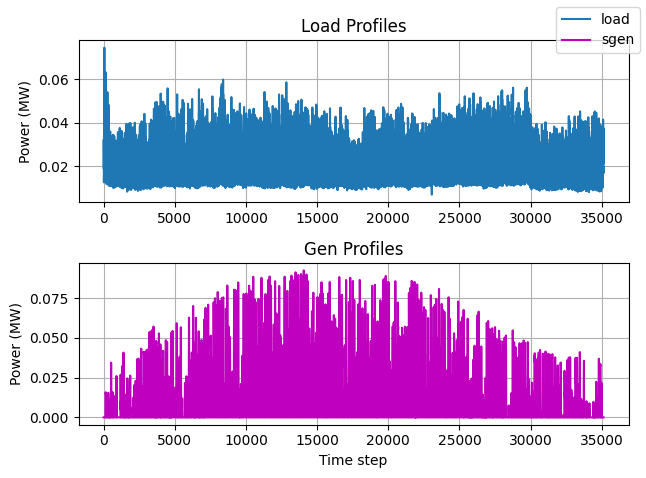

In [ ]:
# Visualize the loads and gen profiles overtime
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1)
axs[0].plot(range(len(load_p)),load_p.sum(axis=1), label="load")
axs[0].set_title("Load Profiles")
# axs[0].set_xlabel("Time step")
axs[0].set_ylabel("Power (MW)")
axs[0].grid(True)
axs[1].plot(range(len(sgen_p)),sgen_p.sum(axis=1), label="sgen", color='m')
axs[1].set_title("Gen Profiles")
axs[1].set_xlabel("Time step")
axs[1].set_ylabel("Power (MW)")
axs[1].grid(True)
fig.tight_layout()
fig.legend()
plt.show()

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Create PandaPower Controller for the Profiles

In [ ]:
import pandapower.timeseries as ts
from pandapower.control.controller.const_control import ConstControl
from pandapower.timeseries.data_sources.frame_data import DFData

ds = DFData(sgen_p)
ConstControl(net, "sgen", "p_mw", element_index=net.sgen.index,
             profile_name=sgen_p.columns, data_source=ds)
ds = DFData(load_p)
ConstControl(net, "load", "p_mw", element_index=net.load.index,
             profile_name=load_p.columns, data_source=ds)
ds = DFData(load_q)
ConstControl(net, "load", "q_mvar", element_index=net.load.index,
             profile_name=load_q.columns, data_source=ds)

This ConstControl has the following parameters: 

index:             2
json_excludes:     ['self', '__class__']

## Create a an Output Writer to Save Results of Time Series PowerFlow

In [ ]:
from pandapower.timeseries import OutputWriter

def create_output_writer(net, time_steps, output_dir):
    ow = OutputWriter(net, time_steps, output_path=output_dir,
                      output_file_type=".xlsx", log_variables=list())
    # these variables are saved to the harddisk after / during the time series loop
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_bus', 'va_degree')
    ow.log_variable('res_bus', 'p_mw')
    ow.log_variable('res_bus', 'q_mvar')
    ow.log_variable('res_line', 'i_ka')

    return ow

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import tempfile
import random
import pandapower as pp

random.seed(10)

output_dir = os.path.join("/content/drive/MyDrive/datasource/datasets",
                          f"{grid_code}")
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
  os.mkdir(output_dir)

Results can be found in your local temp folder: /content/drive/MyDrive/datasource/datasets/1-LV-rural1--0-sw


## Run Time Series PowerFlow

In [ ]:
# time steps to be calculated. Could also be a list with non-consecutive time steps
time_steps = range(0, ds.df.shape[0])

# the output writer with the desired results to be stored to files.
ow = create_output_writer(net, time_steps, output_dir=output_dir)

# the main time series function
ts.run_time_series.run_timeseries(net)

100%|██████████| 35136/35136 [10:30<00:00, 55.68it/s]


In [ ]:
net.res_line


,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,0.001105,0.000366,-0.001105,-0.000369,9.365753e-08,-2.390943e-06,0.001645,0.001646,0.001646,1.021473,-0.219489,1.021385,-0.219736,0.609723
1,-0.006097,-0.002146,0.006099,0.002145,2.775715e-06,-1.249188e-06,0.009141,0.009140,0.009141,1.020569,-0.221086,1.021039,-0.220220,3.385575
2,-0.008826,-0.003080,0.008831,0.003079,5.393016e-06,-6.972177e-08,0.013214,0.013213,0.013214,1.021063,-0.220172,1.021694,-0.218915,4.893954
3,-0.001520,-0.000490,0.001520,0.000489,5.644791e-08,-7.568765e-07,0.002256,0.002256,0.002256,1.021608,-0.219197,1.021647,-0.219068,0.835611
4,0.003465,0.001148,-0.003464,-0.001148,2.652597e-07,-5.973858e-07,0.005156,0.005156,0.005156,1.021667,-0.219028,1.021588,-0.219256,1.909795
5,0.003242,0.001129,-0.003242,-0.001130,3.613789e-07,-9.376120e-07,0.004851,0.004851,0.004851,1.021588,-0.219256,1.021473,-0.219489,1.796720
6,0.003702,0.001129,-0.003702,-0.001129,9.530008e-08,-1.868104e-07,0.005467,0.005468,0.005468,1.021694,-0.218915,1.021667,-0.219028,2.025008
7,-0.007757,-0.002698,0.007757,0.002698,1.794488e-07,-2.356056e-08,0.011610,0.011610,0.011610,1.021039,-0.220220,1.021063,-0.220172,4.299971
8,-0.005400,-0.001919,0.005406,0.001916,5.600359e-06,-3.777291e-06,0.008114,0.008111,0.008114,1.019500,-0.222890,1.020569,-0.221086,3.005301
9,0.004991,0.001777,-0.004986,-0.001781,4.603630e-06,-3.973752e-06,0.007484,0.007487,0.007487,1.021694,-0.218915,1.020742,-0.220436,2.772865


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# root_dir = "/content/drive/MyDrive/datasource/"
# output_dir = os.path.join(root_dir,
#                           "time_series_w_sgen")
bus_vm_pu_data = os.path.join(output_dir, "res_bus/vm_pu.xlsx")
bus_vm_pu_df = pd.read_excel(bus_vm_pu_data, index_col=0)
bus_vm_pu_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,42
0,1.020764,1.021588,1.021317,1.021635,1.019561,1.019578,1.021031,1.021603,1.021552,1.021410,1.021520,1.021008,1.021545,1.020566,1.025
1,1.018630,1.019421,1.018844,1.019502,1.016605,1.016622,1.018463,1.019459,1.019377,1.019131,1.019328,1.018421,1.019351,1.017792,1.025
2,1.017749,1.018787,1.018167,1.018876,1.015472,1.015494,1.017713,1.018827,1.018736,1.018457,1.018676,1.017667,1.018715,1.016932,1.025
3,1.017854,1.018789,1.018122,1.018877,1.015522,1.015542,1.017681,1.018827,1.018745,1.018448,1.018675,1.017633,1.018731,1.016905,1.025
4,1.017843,1.018847,1.018197,1.018936,1.015503,1.015524,1.017739,1.018887,1.018799,1.018509,1.018735,1.017691,1.018783,1.016948,1.025


In [ ]:
bus_p_mw_data = os.path.join(output_dir, "res_bus/p_mw.xlsx")
bus_p_mw_df = pd.read_excel(bus_p_mw_data, index_col=0)
bus_p_mw_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,42
0,0.004495,0.000577,0.001154,0,0.004495,0.000433,0.000963,0.000711,0.001284,0.001926,0.000553,0.001731,0.000132,0.000721,-0.019711
1,0.004446,0.001667,0.003333,0,0.004446,0.001250,0.000953,0.000201,0.001270,0.001905,0.000132,0.005000,0.000381,0.002083,-0.027662
2,0.005846,0.001674,0.003347,0,0.005846,0.001255,0.001253,0.000191,0.001670,0.002505,0.000413,0.005021,0.000336,0.002092,-0.032082
3,0.005232,0.001923,0.003846,0,0.005232,0.001442,0.001121,0.000196,0.001495,0.002242,0.000256,0.005769,0.000227,0.002404,-0.032017
4,0.005747,0.001819,0.003638,0,0.005747,0.001364,0.001232,0.000228,0.001642,0.002463,0.000216,0.005457,0.000269,0.002274,-0.032734


In [ ]:
bus_va_degree_data = os.path.join(output_dir, "res_bus/va_degree.xlsx")
bus_va_degree_df = pd.read_excel(bus_va_degree_data, index_col=0)
bus_va_degree_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,42
0,-0.211164,-0.211759,-0.212386,-0.211672,-0.211599,-0.211610,-0.211922,-0.211778,-0.211820,-0.212175,-0.212121,-0.211934,-0.212027,-0.211944,0
1,-0.280119,-0.281444,-0.277568,-0.281849,-0.269136,-0.269170,-0.276102,-0.281642,-0.281355,-0.279792,-0.280917,-0.275860,-0.281293,-0.273031,0
2,-0.333941,-0.332965,-0.329021,-0.333197,-0.324328,-0.324314,-0.328079,-0.333044,-0.333102,-0.331469,-0.332495,-0.327856,-0.333378,-0.325813,0
3,-0.330863,-0.332041,-0.328914,-0.332258,-0.321955,-0.321982,-0.327598,-0.332118,-0.332091,-0.330719,-0.331632,-0.327402,-0.332356,-0.325110,0
4,-0.346921,-0.343964,-0.340483,-0.344096,-0.339980,-0.339925,-0.340310,-0.343978,-0.344183,-0.342761,-0.343544,-0.340137,-0.344466,-0.339101,0


In [ ]:
bus_q_mvar_data = os.path.join(output_dir, "res_bus/q_mvar.xlsx")
bus_q_mvar_df = pd.read_excel(bus_q_mvar_data, index_col=0)
bus_q_mvar_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,42
0,0.001806,0.000198,0.000397,0,0.001806,0.000149,0.000387,0.000287,0.000516,0.000774,-0.000053,0.000595,-0.000011,0.000248,-0.007180
1,0.001916,0.000929,0.001858,0,0.001916,0.000697,0.000411,0.000009,0.000547,0.000821,0.000048,0.002786,0.000168,0.001161,-0.013465
2,0.002199,0.000959,0.001919,0,0.002199,0.000720,0.000471,0.000014,0.000628,0.000942,0.000059,0.002878,0.000048,0.001199,-0.014502
3,0.002186,0.000976,0.001951,0,0.002186,0.000732,0.000469,0.000032,0.000625,0.000937,0.000008,0.002927,0.000008,0.001219,-0.014524
4,0.001940,0.000994,0.001989,0,0.001940,0.000746,0.000416,0.000032,0.000554,0.000831,0.000020,0.002983,0.000020,0.001243,-0.013984


In [ ]:
bus_i_ka_data = os.path.join(output_dir, "res_line/i_ka.xlsx")
bus_i_ka_df = pd.read_excel(bus_i_ka_data, index_col=0)
bus_i_ka_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.001724,0.008579,0.012631,0.002123,0.005371,0.004655,0.006451,0.011164,0.007504,0.006849,0.002984,0.000187,0.006857
1,0.005406,0.012267,0.021836,0.002547,0.008529,0.008332,0.008789,0.020369,0.008896,0.006859,0.005241,0.000590,0.006873
2,0.005469,0.014309,0.024379,0.002999,0.009795,0.009232,0.010050,0.022489,0.010912,0.008857,0.005704,0.000481,0.008877
3,0.006114,0.014170,0.025061,0.002598,0.009883,0.009551,0.010155,0.023340,0.010353,0.008040,0.005643,0.000322,0.008059
4,0.005877,0.014453,0.025075,0.002826,0.009815,0.009526,0.010129,0.023242,0.010805,0.008602,0.005731,0.000382,0.008622


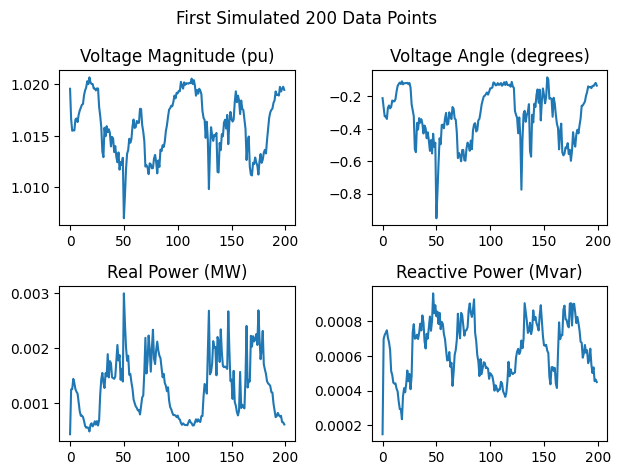

In [ ]:
bus_index = 5
num_points = 200

fig, axs = plt.subplots(2, 2)
fig.suptitle('First Simulated 200 Data Points')
axs[0, 0].plot(bus_vm_pu_df.index[:num_points], bus_vm_pu_df.iloc[:num_points, bus_index])
axs[0, 0].set_title('Voltage Magnitude (pu)')
axs[1, 0].plot(bus_p_mw_df.index[:num_points], bus_p_mw_df.iloc[:num_points, bus_index])
axs[1, 0].set_title('Real Power (MW)')
axs[0, 1].plot(bus_va_degree_df.index[:num_points], bus_va_degree_df.iloc[:num_points, bus_index])
axs[0, 1].set_title('Voltage Angle (degrees)')
axs[1, 1].plot(bus_q_mvar_df.index[:num_points], bus_q_mvar_df.iloc[:num_points, bus_index])
axs[1, 1].set_title('Reactive Power (Mvar)')
# axs[2, 1].plot(bus_i_ka_df.index[:num_points], bus_i_ka_df.iloc[:num_points, bus_index])
# axs[2, 1].set_title('Current (KA)')
fig.tight_layout()
plt.show()

In [ ]:
cols = bus_vm_pu_df.columns
state_data = pd.DataFrame()
for c in cols:
    df_v = bus_vm_pu_df.loc[:, c]
    df_va = bus_va_degree_df.loc[:, c]
    temp_df = pd.DataFrame({'vm_pu'+str(c): df_v,
                        'va_degree'+str(c): df_va})

    state_data = pd.concat([state_data, temp_df], axis=1)
state_data.to_csv(f"{output_dir}/states_data.csv")
state_data.head()

,vm_pu0,va_degree0,vm_pu1,va_degree1,vm_pu2,va_degree2,vm_pu3,va_degree3,vm_pu4,va_degree4,vm_pu5,va_degree5,vm_pu6,va_degree6,vm_pu7,va_degree7,vm_pu8,va_degree8,vm_pu9,va_degree9,vm_pu10,va_degree10,vm_pu11,va_degree11,vm_pu12,va_degree12,vm_pu13,va_degree13,vm_pu42,va_degree42
0,1.020764,-0.211164,1.021588,-0.211759,1.021317,-0.212386,1.021635,-0.211672,1.019561,-0.211599,1.019578,-0.211610,1.021031,-0.211922,1.021603,-0.211778,1.021552,-0.211820,1.021410,-0.212175,1.021520,-0.212121,1.021008,-0.211934,1.021545,-0.212027,1.020566,-0.211944,1.025,0
1,1.018630,-0.280119,1.019421,-0.281444,1.018844,-0.277568,1.019502,-0.281849,1.016605,-0.269136,1.016622,-0.269170,1.018463,-0.276102,1.019459,-0.281642,1.019377,-0.281355,1.019131,-0.279792,1.019328,-0.280917,1.018421,-0.275860,1.019351,-0.281293,1.017792,-0.273031,1.025,0
2,1.017749,-0.333941,1.018787,-0.332965,1.018167,-0.329021,1.018876,-0.333197,1.015472,-0.324328,1.015494,-0.324314,1.017713,-0.328079,1.018827,-0.333044,1.018736,-0.333102,1.018457,-0.331469,1.018676,-0.332495,1.017667,-0.327856,1.018715,-0.333378,1.016932,-0.325813,1.025,0
3,1.017854,-0.330863,1.018789,-0.332041,1.018122,-0.328914,1.018877,-0.332258,1.015522,-0.321955,1.015542,-0.321982,1.017681,-0.327598,1.018827,-0.332118,1.018745,-0.332091,1.018448,-0.330719,1.018675,-0.331632,1.017633,-0.327402,1.018731,-0.332356,1.016905,-0.325110,1.025,0
4,1.017843,-0.346921,1.018847,-0.343964,1.018197,-0.340483,1.018936,-0.344096,1.015503,-0.339980,1.015524,-0.339925,1.017739,-0.340310,1.018887,-0.343978,1.018799,-0.344183,1.018509,-0.342761,1.018735,-0.343544,1.017691,-0.340137,1.018783,-0.344466,1.016948,-0.339101,1.025,0


In [ ]:
full_data = pd.DataFrame()
for c in cols:
    df_v = bus_vm_pu_df.loc[:, c]
    df_va = bus_va_degree_df.loc[:, c]
    df_p = bus_p_mw_df.loc[:, c]
    df_q = bus_q_mvar_df.loc[:, c]
    # df_i = bus_i_ka_df.loc[:, c]
    temp_df = pd.DataFrame({
        'vm_pu'+str(c): df_v,
        'va_degree'+str(c): df_va,
        'p_mw'+str(c): df_p,
        'q_mvar'+str(c): df_q})
    full_data = pd.concat([full_data, temp_df], axis=1)
full_data.to_csv(f"{output_dir}/full_data.csv")
full_data.head()

,vm_pu0,va_degree0,p_mw0,q_mvar0,vm_pu1,va_degree1,p_mw1,q_mvar1,vm_pu2,va_degree2,p_mw2,q_mvar2,vm_pu3,va_degree3,p_mw3,q_mvar3,vm_pu4,va_degree4,p_mw4,q_mvar4,vm_pu5,va_degree5,p_mw5,q_mvar5,vm_pu6,va_degree6,p_mw6,q_mvar6,vm_pu7,va_degree7,p_mw7,q_mvar7,vm_pu8,va_degree8,p_mw8,q_mvar8,vm_pu9,va_degree9,p_mw9,q_mvar9,vm_pu10,va_degree10,p_mw10,q_mvar10,vm_pu11,va_degree11,p_mw11,q_mvar11,vm_pu12,va_degree12,p_mw12,q_mvar12,vm_pu13,va_degree13,p_mw13,q_mvar13,vm_pu42,va_degree42,p_mw42,q_mvar42
0,1.020764,-0.211164,0.004495,0.001806,1.021588,-0.211759,0.000577,0.000198,1.021317,-0.212386,0.001154,0.000397,1.021635,-0.211672,0,0,1.019561,-0.211599,0.004495,0.001806,1.019578,-0.211610,0.000433,0.000149,1.021031,-0.211922,0.000963,0.000387,1.021603,-0.211778,0.000711,0.000287,1.021552,-0.211820,0.001284,0.000516,1.021410,-0.212175,0.001926,0.000774,1.021520,-0.212121,0.000553,-0.000053,1.021008,-0.211934,0.001731,0.000595,1.021545,-0.212027,0.000132,-0.000011,1.020566,-0.211944,0.000721,0.000248,1.025,0,-0.019711,-0.007180
1,1.018630,-0.280119,0.004446,0.001916,1.019421,-0.281444,0.001667,0.000929,1.018844,-0.277568,0.003333,0.001858,1.019502,-0.281849,0,0,1.016605,-0.269136,0.004446,0.001916,1.016622,-0.269170,0.001250,0.000697,1.018463,-0.276102,0.000953,0.000411,1.019459,-0.281642,0.000201,0.000009,1.019377,-0.281355,0.001270,0.000547,1.019131,-0.279792,0.001905,0.000821,1.019328,-0.280917,0.000132,0.000048,1.018421,-0.275860,0.005000,0.002786,1.019351,-0.281293,0.000381,0.000168,1.017792,-0.273031,0.002083,0.001161,1.025,0,-0.027662,-0.013465
2,1.017749,-0.333941,0.005846,0.002199,1.018787,-0.332965,0.001674,0.000959,1.018167,-0.329021,0.003347,0.001919,1.018876,-0.333197,0,0,1.015472,-0.324328,0.005846,0.002199,1.015494,-0.324314,0.001255,0.000720,1.017713,-0.328079,0.001253,0.000471,1.018827,-0.333044,0.000191,0.000014,1.018736,-0.333102,0.001670,0.000628,1.018457,-0.331469,0.002505,0.000942,1.018676,-0.332495,0.000413,0.000059,1.017667,-0.327856,0.005021,0.002878,1.018715,-0.333378,0.000336,0.000048,1.016932,-0.325813,0.002092,0.001199,1.025,0,-0.032082,-0.014502
3,1.017854,-0.330863,0.005232,0.002186,1.018789,-0.332041,0.001923,0.000976,1.018122,-0.328914,0.003846,0.001951,1.018877,-0.332258,0,0,1.015522,-0.321955,0.005232,0.002186,1.015542,-0.321982,0.001442,0.000732,1.017681,-0.327598,0.001121,0.000469,1.018827,-0.332118,0.000196,0.000032,1.018745,-0.332091,0.001495,0.000625,1.018448,-0.330719,0.002242,0.000937,1.018675,-0.331632,0.000256,0.000008,1.017633,-0.327402,0.005769,0.002927,1.018731,-0.332356,0.000227,0.000008,1.016905,-0.325110,0.002404,0.001219,1.025,0,-0.032017,-0.014524
4,1.017843,-0.346921,0.005747,0.001940,1.018847,-0.343964,0.001819,0.000994,1.018197,-0.340483,0.003638,0.001989,1.018936,-0.344096,0,0,1.015503,-0.339980,0.005747,0.001940,1.015524,-0.339925,0.001364,0.000746,1.017739,-0.340310,0.001232,0.000416,1.018887,-0.343978,0.000228,0.000032,1.018799,-0.344183,0.001642,0.000554,1.018509,-0.342761,0.002463,0.000831,1.018735,-0.343544,0.000216,0.000020,1.017691,-0.340137,0.005457,0.002983,1.018783,-0.344466,0.000269,0.000020,1.016948,-0.339101,0.002274,0.001243,1.025,0,-0.032734,-0.013984
